In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, RandomizedSearchCV)
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [31]:
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
train = pd.read_csv('train.csv', parse_dates=['date'])

# Data Preprocessing

In [32]:
# Change column names that are similar but represents a different feature
stores.rename(columns={'type': 'store_type'}, inplace=True)
holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

In [33]:
# Merge datasets
data = train.merge(stores, on = 'store_nbr', how='left')
data = data.merge(oil, on = 'date', how='left')

# Merge with holidays (only non-transferred holidays)
holidays = holidays[holidays['transferred'] == False]
data = data.merge(holidays[['date', 'holiday_type', 'locale']], on='date', how='left')
data['is_holiday'] = data['holiday_type'].notnull().astype(int)

data = data.merge(transactions, on = ['date', 'store_nbr'], how='left')

data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,holiday_type,locale,is_holiday,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN


In [34]:
## Handle missing values
data.fillna({
    'holiday_type': 'Work Day',
    'transactions' : 0,
    'locale'       : 'No Holiday'
}, inplace=True)

# Interpolate missing oil prices
data['dcoilwtico'] = data['dcoilwtico'].interpolate(method='linear', limit_direction='both')

In [35]:
# Create time-based features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

In [36]:
# Feature Engineering: Store×Family lag & rolling‐window statistics
group_cols = ['store_nbr', 'family']
g = data.groupby(group_cols)['sales']

# Create lag and rolling features (all lagged by 1 day):
#   • lag_1         = sales on the previous day
#   • roll_mean_7   = 7-day moving average of sales
#   • roll_std_7    = 7-day moving standard deviation of sales
data['lag_1']        = g.transform(lambda x: x.shift(1))
data['roll_mean_7']  = g.transform(lambda x: x.shift(1).rolling(window=7).mean())
data['roll_std_7']   = g.transform(lambda x: x.shift(1).rolling(window=7).std())

# Drop rows where any of the new features are NaN (i.e. the first few days per group)
data = data.dropna(subset=['lag_1', 'roll_mean_7', 'roll_std_7']) \
           .reset_index(drop=True)

print("After lag/rolling feature creation, data shape:", data.shape)

After lag/rolling feature creation, data shape: (3041874, 22)


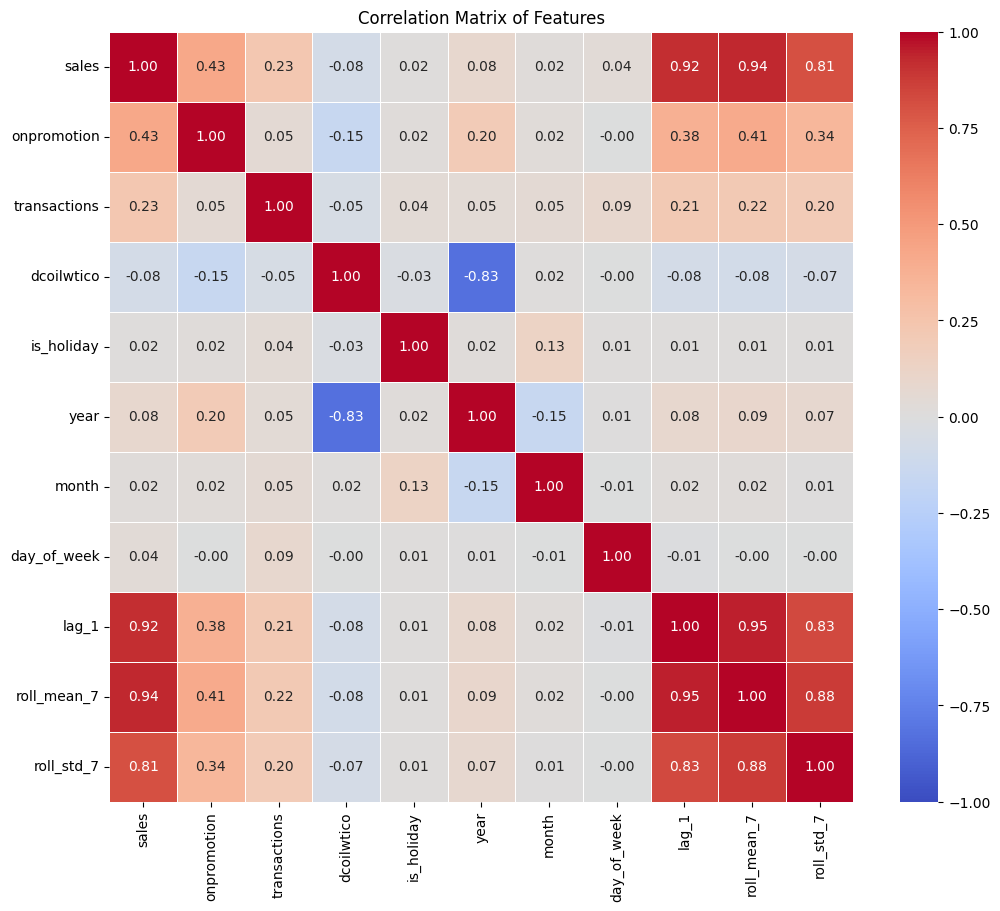

In [37]:
# Correlation Heatmap of Numerical Features

# Select only numeric features

corr_cols = [
    'sales', 'onpromotion', 'transactions', 'dcoilwtico', 'is_holiday',
    'year', 'month', 'day_of_week',
    'lag_1', 'roll_mean_7', 'roll_std_7'
]
corr_matrix = data[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title('Correlation Matrix of Features')
plt.show()

In [38]:
# Drop non-informative & redundant features
#    • id, date: identifiers, not inputs
#    • is_weekend: redundant with day_of_week
to_drop = ['id', 'date', 'is_weekend']
data = data.drop(columns=to_drop)
data.select_dtypes(include='object').columns

Index(['family', 'city', 'state', 'store_type', 'holiday_type', 'locale'], dtype='object')

In [39]:
# Encode categorical columns
label_enc = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = label_enc.fit_transform(data[col].astype(str))

data.head()

,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,holiday_type,locale,is_holiday,transactions,year,month,day_of_week,lag_1,roll_mean_7,roll_std_7
0,1,0,2.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,0.0,2.142857,1.772811
1,1,1,0.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,0.0,0.000000,0.000000
2,1,2,3.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,1.0,1.285714,1.380131
3,1,3,1029.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,1158.0,812.571429,442.221233
4,1,4,0.0,0,18,12,3,13,93.21,5,2,0,1869.0,2013,1,1,0.0,0.000000,0.000000


In [40]:
# Take a random sample of the data
sample_frac = 0.10   # 10% sample → ~300 K rows
data_sample = data.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
print("Sampled data shape:", data_sample.shape)

Sampled data shape: (304187, 19)


In [41]:
X = data_sample.drop('sales', axis=1)
y = data_sample['sales']

In [42]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [43]:
scaler_features = StandardScaler()
X_train = scaler_features.fit_transform(X_train)
X_test = scaler_features.transform(X_test)
X_val = scaler_features.transform(X_val)

In [44]:
tscv = TimeSeriesSplit(n_splits=3)

In [46]:
# XGBoost Tuning
xgb = XGBRegressor(eval_metric='mae', random_state=42, tree_method="gpu_hist")

xgb_param_dist = {
    'n_estimators':       [20, 50, 100, 150, 200, 300, 500, 750, 1000],
    'max_depth':          [3, 5],
    'learning_rate':      [0.05, 0.1],
    'subsample':          [0.5, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree':   [0.5, 0.7, 0.8, 0.9, 1.0],
    'reg_lambda' : [0.1, 0.5, 1, 2, 5, 10],
    'max_depth' : [3, 4, 5, 6, 7, 8],
    'reg_alpha' : [0, 0.1, 0.5, 1, 2, 5, 10],
    

}

rand_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=20,                           # only 20 random combinations
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score='raise'
)

rand_xgb.fit(X_train, y_train)

# Best parameters
print("\nBest XGBoost Parameters:")
print(rand_xgb.best_params_)

# Best model
best_xgb = rand_xgb.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\gregl\Desktop\ML_Projects\Store Sales Forecasting\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost Parameters:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 5, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
